## Data Preprocessing

In [8]:
# import core libraries 
import datetime
import json
import re
import csv
import ast
import pprint
import pathlib
import itertools

# import third-party libraries
import numpy as np
import pandas as pd

# remove warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
# set directory path data
syria_data_dir = pathlib.Path('/Users/adamstueckrath/Desktop/syria_data/')

# tweets_no_rts_csv file path
tweets_no_rts_csv = syria_data_dir / 'tweets_no_retweets' / 'tweets_no_retweets.csv'


## Tweet Data Pre-Processing

In [10]:
def string_to_datetime(tweet_date):
    """
    Turns a datetime string like this: 
    '2017-07-06T18:34:37.000Z' 
    to a Python datetime object like this -> 2017-07-06 18:34:41
    """
    return datetime.datetime.strptime(tweet_date, "%Y-%m-%dT%H:%M:%S.%fZ")


In [11]:
# load tweets into dataframe from csv file
tweets_no_rts_df = pd.read_csv(tweets_no_rts_csv, header=0,
                               parse_dates=['tweet_created_at'],
                               usecols=['tweet_id', 'tweet_id_str',
                                        'tweet_lang','tweet_created_at',
                                        'user_name','user_id_str','tweet_text'],
                               date_parser=string_to_datetime)


### Filter tweets for english only

In [12]:
tweets_no_rts_df.shape

(1160088, 7)

In [13]:
tweets_no_rts_df = tweets_no_rts_df[tweets_no_rts_df['tweet_lang'] =='en']
tweets_no_rts_df = tweets_no_rts_df.reset_index(drop=True)


In [14]:
tweets_no_rts_df.shape

(638161, 7)

### Clean tweet text

In [15]:
def clean_text(text):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    use this for removing digits -> return re.sub('\d+', '', input_text)
    '''
    text = text.lower()
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())


In [16]:
tweets_no_rts_df['tweet_text_clean'] = tweets_no_rts_df['tweet_text'].apply(clean_text)


## Sentiment Analysis 

In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    '''
    Utility function to classify the polarity of a tweet
    using nltk. analysis variable returns the following dict: 
    {'neg': 0.122, 'neu': 0.641, 'pos': 0.237, 'compound': 0.4215}
    The compound value here conveys the overall positive or negative user experience.
    Examples: 
    https://www.programcreek.com/python/example/100005/nltk.sentiment.vader.SentimentIntensityAnalyzer
    https://opensourceforu.com/2016/12/analysing-sentiments-nltk/
    '''
    analysis = analyzer.polarity_scores(text)
    return analysis['compound']


In [18]:
tweets_no_rts_df['tweet_sentiment_compound'] = tweets_no_rts_df['tweet_text_clean'].apply(analyze_sentiment)


I had originally gone with the NLTK documentation of suggestion of 0.5 and -0.5 as positive/negative. However my results too compact: 


In [19]:
def sentiment_score_suggested(compound):
    if compound > 0.5:
        return 1
    elif compound < -0.5:
        return -1
    else:
        return 0
    

In [20]:
tweets_no_rts_df['tweet_sentiment_score'] = tweets_no_rts_df['tweet_sentiment_compound'].apply(sentiment_score_suggested)
tweets_no_rts_df['tweet_sentiment_score'].value_counts()


 0    434390
-1    135277
 1     68494
Name: tweet_sentiment_score, dtype: int64

In [21]:
def sentiment_score(compound):
    if compound > 0.2:
        return 1
    elif compound < -0.2:
        return -1
    else:
        return 0
    

In [22]:
tweets_no_rts_df['tweet_sentiment_score'] = tweets_no_rts_df['tweet_sentiment_compound'].apply(sentiment_score)
tweets_no_rts_df['tweet_sentiment_score'].value_counts()


 0    244735
-1    238936
 1    154490
Name: tweet_sentiment_score, dtype: int64

In [23]:
def sentiment_label(score):
    if score == 1:
        return 'positive'
    elif score == -1:
        return 'negative'
    else:
        return 'neutral'
    

In [24]:
tweets_no_rts_df['tweet_sentiment_label'] = tweets_no_rts_df['tweet_sentiment_score'].apply(sentiment_label)


In [25]:
tweets_no_rts_df['tweet_sentiment_label'].value_counts()


neutral     244735
negative    238936
positive    154490
Name: tweet_sentiment_label, dtype: int64

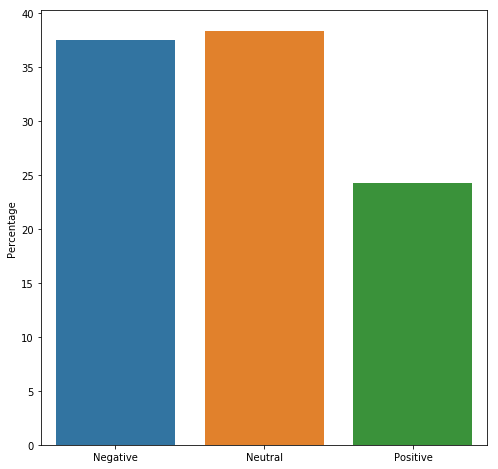

In [31]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(figsize=(8, 8))
counts = tweets_no_rts_df.tweet_sentiment_score.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
plt.savefig('sentiment.png')